# TP1

#Imports y funciones auxiliares

In [ ]:
library(MASS)
library(ggplot2)
library(rpart)
library(class)

set.seed(42)

In [ ]:
k_fold_cv_tree <- function(data, num_folds = 5) {
  # Mezclar aleatoriamente los datos
  data <- data[sample(1:nrow(data)), ]

  # Dividir los datos en 'num_folds' subconjuntos
  folds <- cut(seq(1, nrow(data)), breaks = num_folds, labels = FALSE)

  # Inicializar vector para almacenar la precisión de cada pliegue
  accuracies <- numeric(num_folds)

  # Realizar el proceso de k-fold cross-validation
  for (i in 1:num_folds) {
    # Separar los datos de entrenamiento y validación
    test_indices <- which(folds == i, arr.ind = TRUE)
    test_data <- data[test_indices, ]
    train_data <- data[-test_indices, ]

    # Separar las características y la clase
    test_x <- test_data[, -ncol(test_data)]    # Todas las columnas menos la clase
    test_y <- test_data$class

    fit <- rpart(class ~ ., data = train_data)
    predictions <- predict(fit, test_x, type = "class")
    accuracies[i] <- mean(predictions == test_y)
  }

  # Retornar la precisión promedio de todos los pliegues
  mean_accuracy <- mean(accuracies)
  return(mean_accuracy)
}

In [ ]:
k_fold_cv_knn <- function(data, k = 3, num_folds = 5) {
  # Mezclar aleatoriamente los datos
  data <- data[sample(1:nrow(data)), ]

  # Dividir los datos en 'num_folds' subconjuntos
  folds <- cut(seq(1, nrow(data)), breaks = num_folds, labels = FALSE)

  # Inicializar vector para almacenar la precisión de cada pliegue
  accuracies <- numeric(num_folds)

  # Realizar el proceso de k-fold cross-validation
  for (i in 1:num_folds) {
    # Separar los datos de entrenamiento y validación
    test_indices <- which(folds == i, arr.ind = TRUE)
    test_data <- data[test_indices, ]
    train_data <- data[-test_indices, ]

    # Separar las características y la clase
    train_x <- train_data[, -ncol(train_data)]  # Todas las columnas menos la clase
    train_y <- train_data$class
    test_x <- test_data[, -ncol(test_data)]    # Todas las columnas menos la clase
    test_y <- test_data$class

    # Ajustar un modelo k-NN con k=3 (puedes cambiarlo a otro modelo)
    knn_pred <- knn(train = train_x, test = test_x, cl = train_y, k = k)

    # Calcular la precisión (accuracy)
    accuracies[i] <- mean(knn_pred == test_y)
  }

  # Retornar la precisión promedio de todos los pliegues
  mean_accuracy <- mean(accuracies)
  return(mean_accuracy)
}

# Ejercicio 1

## Diagonales

In [ ]:
# Función para crear la matriz de covarianza
covM <- function(d, C) diag(C * sqrt(d), d)

diagonales <- function(n, d, C) {
  # Clase 0
  c0 <- mvrnorm(n = n / 2, mu = rep(-1, d), Sigma = covM(d, C))
  c0 <- cbind(c0, 0)
  # Clase 1
  c1 <- mvrnorm(n = n / 2, mu = rep(1, d), Sigma = covM(d, C))
  c1 <- cbind(c1, 1)

  flist <- rbind(c0, c1)

  # Crear DataFrame
  df <- as.data.frame(flist)
  colnames(df) <- c(paste0("dim_", 0:(d - 1)), "class")

  df$class <- as.factor(df$class)

  return(df)
}

## Espirales

In [ ]:
cartesian_to_polar <- function(x, y) {
  rho = sqrt(x^2+y^2)
  theta = atan2(y, x)
  return(c(rho, theta))
}

is_inside_curve <- function(rho, theta, npi) {
  rho_curve1 <- (theta + (npi-1)*pi) / (4 * pi)
  rho_curve2 <- (theta + npi*pi) / (4 * pi)
  return(rho_curve1 <= rho && rho <= rho_curve2)
}

is_inside_curves <- function(x, y) {
  polar <- cartesian_to_polar(x, y)
  rho <- polar[1]
  theta <- polar[2]
  return(is_inside_curve(rho, theta, 1) || is_inside_curve(rho, theta, 3) || is_inside_curve(rho, theta, 5))
}

espirales <- function(n) {
  count0 <- 0
  count1 <- 0
  x_s <- numeric()
  y_s <- numeric()
  classes <- numeric()
  while ((count0+count1) < n) {
    x <- runif(1, -1, 1)
    y <- runif(1, -1, 1)
    if (sqrt(x^2+y^2) < 1) {
      if (is_inside_curves(x, y)) {
        if (count0 < floor(n / 2)) {
          x_s <- c(x_s, x)
          y_s <- c(y_s, y)
          classes <- c(classes, 0)
          count0 <- count0 + 1
        }
      } else {
        if (count1 < floor(n / 2)) {
          x_s <- c(x_s, x)
          y_s <- c(y_s, y)
          classes <- c(classes, 1)
          count1 <- count1 + 1
        }
      }
    }
  }

  df <- data.frame(dim_0 = x_s, dim_1 = y_s, class = as.factor(classes))
  return(df)
}

# Ejercicio 2

## Diagonales

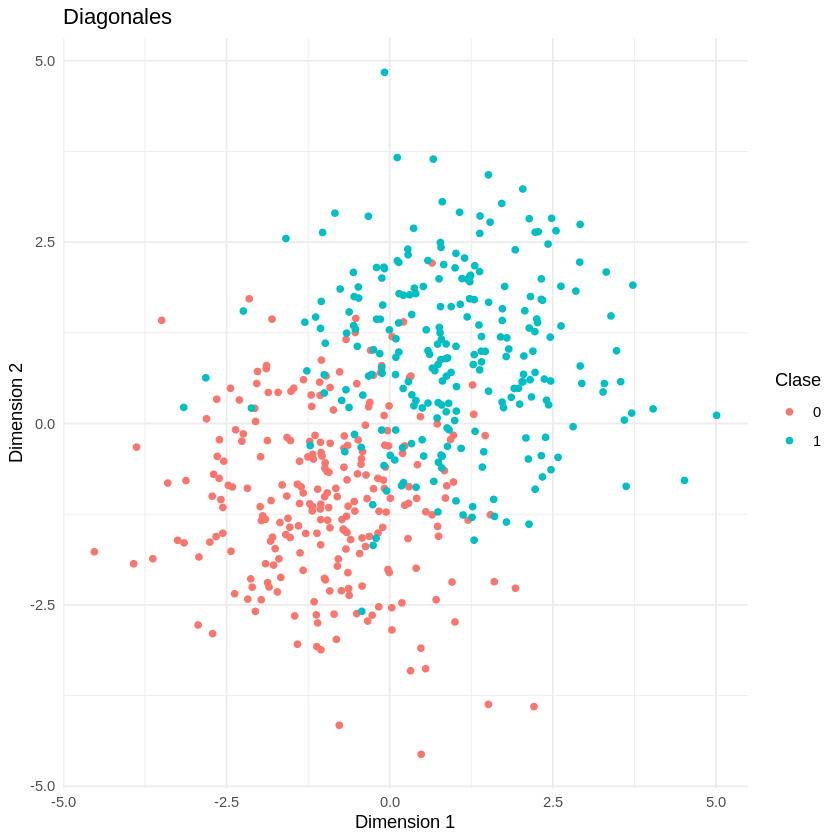

In [ ]:
df <- diagonales(n = 500, d = 2, C = 1)

ggplot(df, aes(x = dim_0, y = dim_1, color = class)) +
  geom_point() +
  labs(title = "Diagonales",
       x = "Dimension 1",
       y = "Dimension 2",
       color = "Clase") +
  theme_minimal()


## Espirales

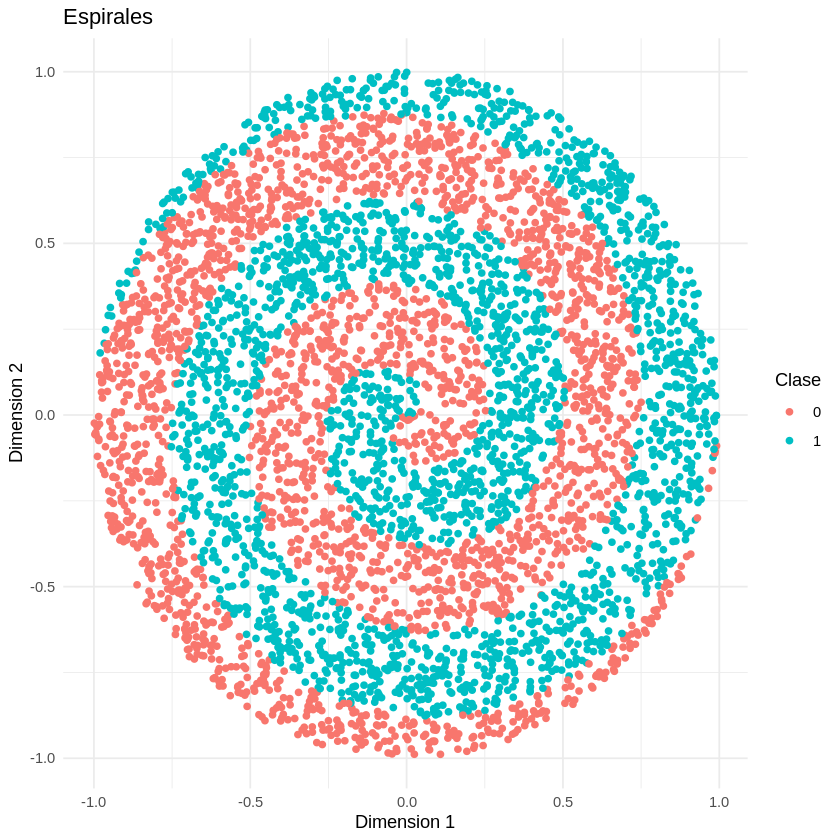

In [ ]:
df <- espirales(5000)

ggplot(df, aes(x = dim_0, y = dim_1, color = class)) +
  geom_point() +
  labs(title = "Espirales",
       x = "Dimension 1",
       y = "Dimension 2",
       color = "Clase") +
  theme_minimal()

# Ejercicio 3

## Diagonales

In [ ]:
d <- 2
df_train_diag <- diagonales(n = 300, d = d, C = 1)
df_test_diag <- diagonales(n = 10000, d = d, C = 1)

### Directo

#### Árboles de decisión

In [ ]:
tree_model_diag <- rpart(class~., data = df_train_diag, method = "class")

tree_predictions_diag <- predict(tree_model_diag, df_test_diag[, c(paste0("dim_", 0:(d - 1)))], type = "class")

tree_error_diag <- mean(tree_predictions_diag != df_test_diag$class)

cat("Error de test para arboles de decisión en diagonales de forma directa:", tree_error_diag, "\n")

Error de test para arboles de decisión en diagonales de forma directa: 0.1329 


#### KNN

In [ ]:
knn_predictions_diag <- knn(train = df_train_diag[, c(paste0("dim_", 0:(d - 1)))],
                          test = df_test_diag[, c(paste0("dim_", 0:(d - 1)))],
                          cl = df_train_diag$class,
                          k = 5)

knn_error_diag <- mean(knn_predictions_diag != df_test_diag$class)
cat("Error de test para k-vecinos (k=5) en diagonales de forma directa:", knn_error_diag, "\n")

Error de test para k-vecinos (k=5) en diagonales de forma directa: 0.1225 


### K-fold

#### Árboles de decisión

In [ ]:
mean_accuracy <- k_fold_cv_tree(df_train_diag)
cat("Error promedio de arboles de decisión en diagonales usando k-fold:", 1-mean_accuracy, "\n")

Error promedio de arboles de decisión en diagonales usando k-fold: 0.13 


#### KNN

In [ ]:
mean_accuracy <- k_fold_cv_knn(df_train_diag)
cat("Error promedio de KNN en diagonales usando k-fold:", 1-mean_accuracy, "\n")

Error promedio de KNN en diagonales usando k-fold: 0.14 


## Espirales

In [ ]:
df_train_esp <- espirales(300)
df_test_esp <- espirales(10000)

### Directo

#### Árboles de decisión

In [ ]:
tree_model_esp <- rpart(class~., data = df_train_esp, method = "class")

tree_predictions_esp <- predict(tree_model_esp, df_test_esp[, c("dim_0", "dim_1")], type = "class")

tree_error_esp <- mean(tree_predictions_esp != df_test_esp$class)

cat("Error de test para arboles de decisión en espirales de forma directa:", tree_error_esp, "\n")

Error de test para arboles de decisión en espirales de forma directa: 0.2462 


#### KNN

In [ ]:
knn_predictions_esp <- knn(train = df_train_esp[, c("dim_0", "dim_1")],
                          test = df_test_esp[, c("dim_0", "dim_1")],
                          cl = df_train_esp$class,
                          k = 5)

knn_error_esp <- mean(knn_predictions_esp != df_test_esp$class)
cat("Error de test para k-vecinos (k=5) en espirales de forma directa:", knn_error_esp, "\n")

Error de test para k-vecinos (k=5) en espirales de forma directa: 0.1618 


### K-fold

#### Árboles de decisión

In [ ]:
mean_accuracy <- k_fold_cv_tree(df_train_esp)
cat("Error promedio de arboles de decisión en espirales usando k-fold:", 1-mean_accuracy, "\n")

Error promedio de arboles de decisión en espirales usando k-fold: 0.3266667 


#### KNN

In [ ]:
mean_accuracy <- k_fold_cv_knn(df_train_esp)
cat("Error promedio de KNN en espirales usando k-fold:", 1-mean_accuracy, "\n")

Error promedio de KNN en espirales usando k-fold: 0.1666667 
